<a href="https://colab.research.google.com/github/politeles/audio_classification/blob/main/EntrenamientoRedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm

In [2]:
import numpy as np

# Entrenamiento de un clasificador de audio usando una red neuronal
En este cuaderno vamos a realizar la operación conocida como transferencia de conocimiento, donde usamos una red neuronal pre-entrenada. En nuestro caso, utilizaremos [YamNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet). Una red que clasifica 521 tipos diferentes de sonido.

Vamos a utilizar el conjunto de datos VADS que contiene 9 clases de sonidos de violín. El proceso de entrenamiento es el siguiente:
 1. Descargar el dataset VADS.
 2. Calcular el espectrograma de MEL con usando las primeras capas de la red YamNET.
 3. Con esos valores pre calculados, comenzamos el entrenamiento de una red que definimos nosotros.
 4. Modificamos la red YamNet para sustituir las últimas capas por las de nuestro modelo.


In [3]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [4]:
!pip install datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.7 MB/s eta 0:00:00


## Descarga y preprocesamiento del dataset VADS
Descargamos el dataset desde HuggingFace y realizamos unas operaciones para poder usarlo con la red YamNet.

In [5]:
from datasets import load_dataset

In [6]:
vads = load_dataset('politeles/vads')

README.md:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2515 [00:00<?, ? examples/s]

### Downsampling a 16Khz
Hacemos un downsampling del audio que está grabado a 48Khz a 16Khz. Esta operación es necesaria porque la red que vamos a utilizar, YamNet, está entrenada a 16Khz.

In [7]:
from datasets import Audio

In [8]:
vads = vads.cast_column("audio", Audio(sampling_rate=16_000))

### Eliminación de columnas
Vamos a eliminar columnas que no necesitamos (el tipo de micrófono, la cuerda, la nota). Y también vamos a renombrar la columna *technique* a label.
Esto lo hacemos porque la columna *technique* va a ser nuestra variable objetivo.

In [9]:
vads = vads.rename_column("technique", "label")

In [10]:
vads = vads.remove_columns(["microphone","string","note"])

### Partición entrenamiento / test
Usamos el 80% de los datos para entrenamiento y el 20% para test.
De ese 80%, un 20% se utilizará para la validación durante el proceso de entrenamiento.


In [11]:
train_test_split = vads['train'].train_test_split(test_size=0.2)

Unificamos todas las particiones en un único dataset

In [12]:
from datasets import DatasetDict, Dataset

In [13]:
train_test_valid_ds = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test'],
   })

# Entrenamiento de YamNet
En este paso vamos a descargar la versión de YamNet, vamos a realizar un ejemplo de clasificación y vamos a calcular todos los embeddings con los que alimentar a nuestro modelo para hacer la transferencia de conocimiento.

In [14]:
import tensorflow as tf

In [15]:
import tensorflow_hub as hub

In [16]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

## Ejemplo de clasificación
 Realizamos un ejemplo de clasificación de sonido y obtenemos los metadatos que nos proporciona la red, como los embedings

In [17]:
sample = vads["train"][0]["audio"]["array"][:15600]

In [18]:
predictions, embeddings, log_mel = yamnet_model(sample)

In [19]:
embeddings

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[0.        , 0.        , 0.07631061, ..., 0.07038089, 0.0119719 ,
        0.        ]], dtype=float32)>

## Preprocesamos todo el dataset para obtener los embeddings
Definimos una función para procesar los embeddings, tenemos en cuenta que hay más embeddings que ejemplos, porque YamNet esta preparada para ventanas de 0.960 segundos de audio, mientras que los ejemplos del dataset VADS duran 1 segundo.

Posteriormente calculamos para cada componente, train, test y validation, los embeddings que usaremos para realizar el entrenamiento y la validación

In [20]:
def preproces_sample(ds:Dataset):
  samples, labels = [], []
  for elem in tqdm(ds):
    audio_data = elem['audio']['array']
    scores, embeddings, spectrogram = yamnet_model(audio_data)

    # Check if embeddings is None or contains None values
    if embeddings is None or np.any(np.equal(embeddings, None)):
        print(f"Skipping sample with None embeddings: {elem}")  # Add this line to identify problematic samples
        continue  # Skip this sample and proceed to the next

    for feature in embeddings:
      samples.append(feature)
      labels.append(elem['label'])
  samples = np.asarray(samples)
  labels = np.asarray(labels)
  return samples, labels

In [21]:
samples, labels = preproces_sample(train_test_valid_ds['train'])

100%|██████████| 2012/2012 [00:20<00:00, 98.93it/s]


In [22]:
samples.shape

(3762, 1024)

In [23]:
samples_test, labels_test = preproces_sample(train_test_valid_ds['test'])

100%|██████████| 503/503 [00:05<00:00, 93.03it/s]


### Definición del modelo
Nuestro modelo sólo tiene dos capas: en la primera usa los embeddings calculados por las primeras capas de YamNet. Las siguientes capas es una capa densa que tiene como resultado los 9 posibles clases

In [24]:
#parametros
regularization = 0.03
num_hidden = 64 # or 512
activation = 'softmax' # or 'relu'
batch_size = 64
epochs = 250

In [25]:
#número de clases:
my_classes = vads['train'].features['label'].num_classes

In [26]:
vads_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(num_hidden, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization)),
    tf.keras.layers.Dense(my_classes,activation=activation)
], name='vads_model')

In [27]:
vads_model.summary()

Model: "vads_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,185 (258.54 KB)

 Trainable params: 66,185 (258.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
vads_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 optimizer="adam",
                 metrics=['accuracy'])

In [29]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./violin_y.keras', monitor='val_loss', save_best_only=True),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=15, verbose=1,
                                                      min_lr=0.000001)]

In [30]:
history = vads_model.fit(samples,labels,epochs=epochs,validation_split=0.2,batch_size=batch_size,
                       callbacks=callbacks)

Epoch 1/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4972 - loss: 4.2275 - val_accuracy: 0.7185 - val_loss: 1.7953 - learning_rate: 0.0010
Epoch 2/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7502 - loss: 1.5201 - val_accuracy: 0.7809 - val_loss: 1.1368 - learning_rate: 0.0010
Epoch 3/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7828 - loss: 1.0849 - val_accuracy: 0.7663 - val_loss: 0.9771 - learning_rate: 0.0010
Epoch 4/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8027 - loss: 0.9061 - val_accuracy: 0.8088 - val_loss: 0.8897 - learning_rate: 0.0010
Epoch 5/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.8736 - val_accuracy: 0.7981 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 6/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8144 - loss: 0.7978 - val_accuracy: 0.8313 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 7/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8531 - loss: 0.7376 - val_ac

### Evaluación del modelo con datos de test
Ahora validamos el modelo con los datos de test y calculamos las medida de accuracy

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [32]:
y_pred = vads_model.predict(samples_test)
y_pred_classes = np.argmax(y_pred, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [33]:
accuracy = accuracy_score(labels_test, y_pred_classes)

In [34]:
f1 = f1_score(labels_test, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class

In [35]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.8565400843881856


In [36]:
print(f"F1 Score: {f1}")

F1 Score: 0.8537483858383256


In [37]:
report = classification_report(labels_test, y_pred_classes)

In [38]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        78
           1       0.72      0.53      0.61        49
           2       0.72      0.85      0.78       143
           3       0.70      0.68      0.69        34
           4       0.59      0.67      0.62        30
           5       0.99      0.96      0.97        94
           6       0.92      0.95      0.94       196
           7       0.85      0.56      0.68        78
           8       0.89      0.91      0.90       246

    accuracy                           0.86       948
   macro avg       0.82      0.79      0.80       948
weighted avg       0.86      0.86      0.85       948



### Mezclar el modelo con YamNet
Ahora tenemos que reemplazar las dos últimas capas finales de YamNet con el modelo que hemos creado.

In [48]:
@tf.keras.utils.register_keras_serializable()
def get_yamnnet_embeddings(audio):
  _, embeddings, _ = yamnet_model(audio)
  return embeddings

In [49]:
input_audio = tf.keras.Input(shape=(None,),dtype=tf.float32)

In [50]:
embeddings = tf.keras.layers.Lambda(get_yamnnet_embeddings,output_shape=(1024,))(input_audio)

In [51]:
output = vads_model(embeddings)

In [52]:
unified_model = tf.keras.Model(inputs=input_audio, outputs=output)

In [53]:
unified_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer="adam",
                      metrics=['accuracy'])

### Guardar el modelo en disco

In [54]:
unified_model.save('/data/unified_model.keras')

In [55]:
vads_model.save('/data/vads_model.keras')

## Matriz de confusión
Calculamos la matriz de confusión para todo el dataset

In [57]:
samples, labels = preproces_sample(vads['train'])

100%|██████████| 2515/2515 [00:22<00:00, 112.03it/s]


In [60]:
y_pred = []
for sample in tqdm(samples):
  y_pred.append(vads_model(sample.reshape(1,-1)))

100%|██████████| 4710/4710 [00:11<00:00, 419.68it/s]


In [62]:
id2label_fn = vads["train"].features['label'].int2str

In [75]:
true_labels = [id2label_fn(int(label)) for label in labels]

In [71]:
labels[0].dtype

dtype('int64')

In [80]:
result = [id2label_fn(int(np.argmax(label))) for label in y_pred]

In [83]:
len(result)

4710

In [84]:
len(labels)

4710

In [88]:
labels_txt = []
for i in range(9):
  print(i)
  labels_txt.append(id2label_fn(i))

0
1
2
3
4
5
6
7
8


In [89]:
labels_txt

['bariolage',
 'chords',
 'doublestops',
 'legato',
 'martele',
 'pizz',
 'ricochet',
 'spicatto',
 'sulponticello']

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [92]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, result, labels=labels_txt)

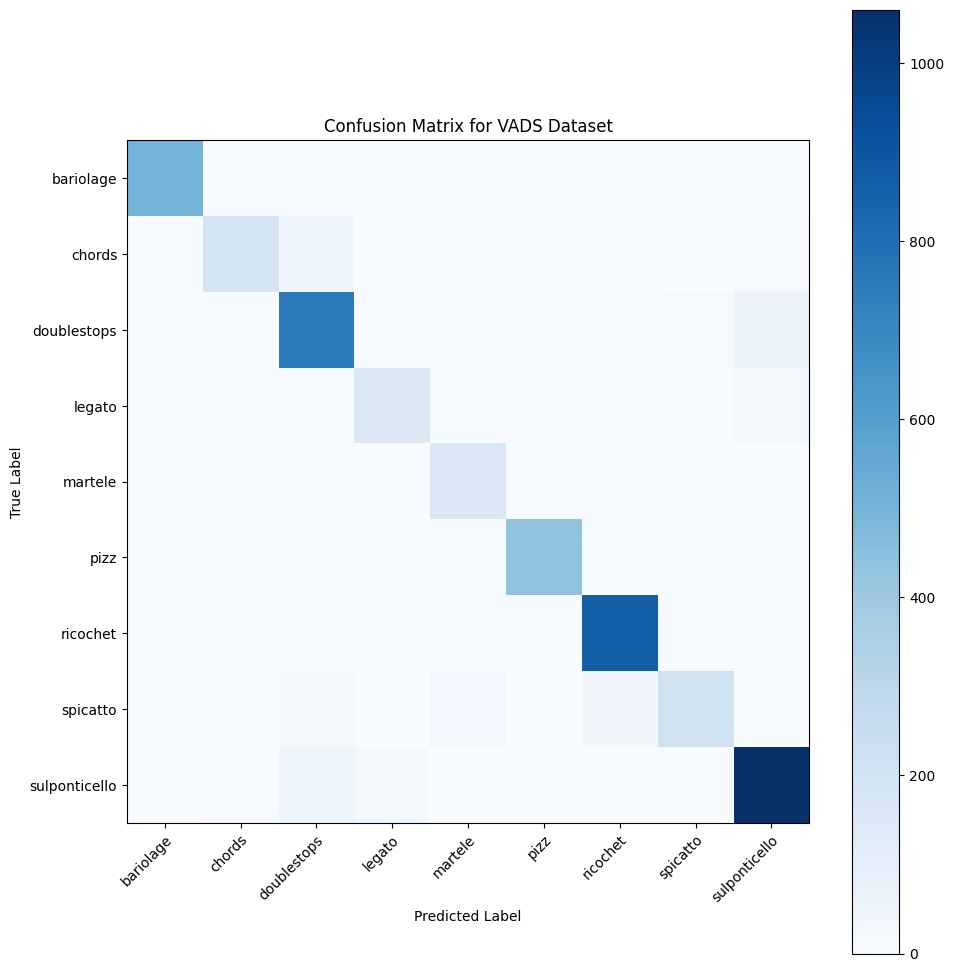

In [95]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set labels, title, and ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels_txt,
       yticklabels=labels_txt,
       title="Confusion Matrix for VADS Dataset",
       ylabel="True Label",
       xlabel="Predicted Label")

# Rotate x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Display the plot
plt.tight_layout()
plt.show()